# Run QNet on Lander

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
from tqdm.notebook import trange
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sys.path.append('RL_lib/Agents/PPO')
sys.path.append('RL_lib/Utils')
sys.path.append('../')

import QLearn
import env_lib
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
import utils
from env_gaudet_lander import LanderEnvironment, int_to_bin, bin_to_int

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed
PPO Policy 1

Instructions for updating:
Use keras.layers.dense instead.

Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Actions
[[0.]
 [1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0'])


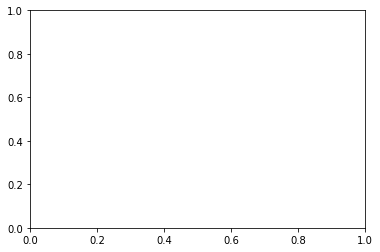

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

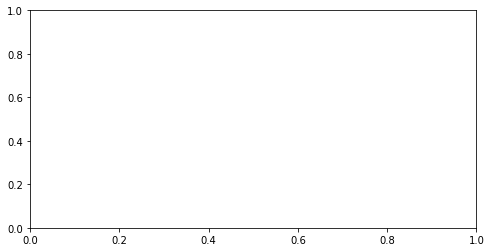

In [4]:
env = LanderEnvironment()
obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True, discretize=True)

fname = "opt_discrete_4km"
input_normalizer = utils.load_run(policy,fname)

## Baseline Performances

In [5]:
def ppo_policy(s):
    s_norm = input_normalizer.apply(s)
    a = policy.sample(s_norm.reshape(1,-1))
    return bin_to_int(list(a[1][0]))

def random_policy(s):
    return np.random.randint(16)

In [7]:
R_rand = QLearn.heuristic_demo(random_policy,env,100)

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
queue fixed
Flat Constraint


*** ATT VIO TYPE CNT:  [0. 0. 1.]



In [10]:
policy.test_mode=True
R_ppo = QLearn.heuristic_demo(ppo_policy,env,10)

In [6]:
policy.test_mode=True
mem_ppo = QLearn.heuristic_memory_demo(ppo_policy,env,20,fname='demo_disc.pkl')

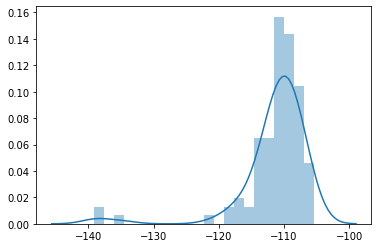

In [11]:
sns.distplot(R_rand)

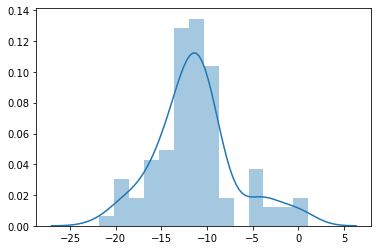

In [16]:
sns.distplot(R_ppo)

## Running Q Agent with Guidance

In [ ]:
N_ep = 2000
policy.test_mode=True
agent = QLearn.QAgent(env, net_type='QNet', f_heur=ppo_policy, n_heur=100,
                    update_steps=10, N_hid=100, eps0=0.9, gamma=0.99, n_eps=1500, memory_size=100000, minibatch_size=25)
R_ep, agent, env = do_run(agent, env, N_ep)

In [9]:
agent.nn.sess.close()

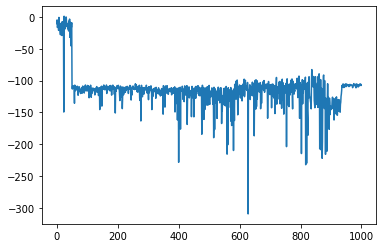

In [26]:
plt.plot(R_ep)

Using demo memory

In [19]:
del agent

In [ ]:
N_ep = 50000
dmem=pickle.load(open('demo_disc.pkl','rb'))
env = LanderEnvironment()
agent = QLearn.QAgent(env,net_type='MLPQNet',hidden_layers=[160, 80],alpha=1e-4,gamma=0.99,eps0=0.25,n_eps=40000,minibatch_size=50,memory_size=500000,demo_memory=dmem,n_demo=50)
fname = 'lander_demo_test_20_3_mlp1'
R, steps, agent, env = QLearn.do_run(agent, env, N_ep, save_name = fname, show_progress=True)

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed


*** ATT VIO TYPE CNT:  [0. 0. 1.]
*** ATT VIO TYPE CNT:  [ 0. 28. 73.]
*** ATT VIO TYPE CNT:  [  0.  63. 139.]
*** ATT VIO TYPE CNT:  [  0.  94. 210.]
*** ATT VIO TYPE CNT:  [  0. 132. 273.]
*** ATT VIO TYPE CNT:  [  0. 146. 359.]
*** ATT VIO TYPE CNT:  [  0. 190. 415.]
*** ATT VIO TYPE CNT:  [  0. 212. 493.]
*** ATT VIO TYPE CNT:  [  0. 235. 572.]
*** ATT VIO TYPE CNT:  [  0. 258. 649.]
*** ATT VIO TYPE CNT:  [  0. 317. 692.]
*** ATT VIO TYPE CNT:  [  0. 350. 759.]
*** ATT VIO TYPE CNT:  [  0. 376. 834.]
*** ATT VIO TYPE CNT:  [  0. 408. 903.]
*** ATT VIO TYPE CNT:  [  0. 431. 981.]
*** ATT VIO TYPE CNT:  [   0.  470. 1043.]
*** ATT VIO TYPE CNT:  [   0.  493. 1120.]
*** ATT VIO TYPE CNT:  [   0.  518. 1196.]
*** ATT VIO TYPE CNT:  [   0.  554. 1261.]
*** ATT VIO TYPE CNT:  [   0.  581. 1336.]
*** ATT VIO TYPE CNT:  [   0.  618. 1400.]
*** ATT VIO TYPE CNT:  [   0.  661. 1457.]
*** ATT VIO TYPE CNT:  [   0.  698. 1521.]
*** ATT VIO TYPE CNT:  [   0.  723. 1596.]
*** ATT VIO TYPE CNT: 

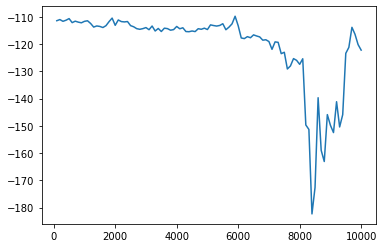

In [18]:
x,R_s=R.smooth()
plt.plot(x,R_s)